<a href="https://colab.research.google.com/github/abelowska/eegML/blob/main/Classes_05_model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model selection: in a search for the best model

In this notebook you will learn various techniques to help you in the model selection procedure:
- [Cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/) procedure used to evaluate machine learning models on a limited data sample.
- [Grid search](https://medium.com/fintechexplained/what-is-grid-search-c01fe886ef0a) used to find the optimal hyperparameters of a model which results in the most ‘accurate’ predictions.
- Statistical tests for comparing models' performance. 

---
**Let's find the best model of BMI vs Schooling**

Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

import io
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold

from scipy import stats

import warnings

warnings.filterwarnings("ignore")

In [ ]:
# parameters for plotting
plt.rcParams["figure.figsize"] = (10,7)

In [ ]:
# constants
test_size=0.2 
random_state=42

### Load the Life Expectancy Dataset

In [ ]:
# To upload from your local drive, start with the following code. 
# It will prompt you to select a file. Click on “Choose Files” 
# then select and upload the .csv file you downloaded. 

from google.colab import files
uploaded = files.upload()

Saving Life_Expectancy_Data.csv to Life_Expectancy_Data.csv


In [ ]:
# make sure the filename matches the name of the uploaded file 
life_expectancy_data = pd.read_csv(io.BytesIO(uploaded['Life_Expectancy_Data.csv']))
life_expectancy_df = life_expectancy_data.copy()

In [ ]:
life_expectancy_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


### Prepare data

Drop NaN values


In [ ]:
life_expectancy_df = life_expectancy_df.dropna() 

Select X and y sets

In [ ]:
# select BMI and GDP columns
X = life_expectancy_df[[" BMI "]]
y = life_expectancy_df[["Schooling"]]

Train-test split

In [ ]:
test_size

0.2

In [ ]:
# to ensure repeatability of splits, we set the random state
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=test_size, 
    random_state=random_state
)

In [ ]:
print(f"Shape of the X train dataset: {X_train.shape}")
print(f"Shape of the X test dataset: {X_test.shape}")
print(f"Shape of the y train dataset: {y_train.shape}")
print(f"Shape of the y test dataset: {y_test.shape}")

Shape of the X train dataset: (1319, 1)
Shape of the X test dataset: (330, 1)
Shape of the y train dataset: (1319, 1)
Shape of the y test dataset: (330, 1)


---
## Best model: Problem 1 - Choosing

Let's recap our problem of finding the best model of BMI vs Schooling. In last notebook (classes_03) we've used seven different models to estimate the effect of BMI to Schooling:

- linear regression
- SVR with linear kernel, epsilon = 0.1 and C = 0.0001;
- SVR with linear kernel, epsilon = 0.1 and C = 1.0;
- SVR with linear kernel, epsilon = 2.0 and C = 1.0;
- SVR with rbf kernel, epsilon = 2.0 and C = 1.0;
- KNN with K=5;
- DecisionTree;

Which model was the best?

**And what does it mean - *\"the best model\"*?**

As everywhere, we have to have a metric that says what is better. Until now, when we said *\"the best model\"*, we were comparing the results on a **test set**. But the test set should not be used for comparison.

What is the test set for? 

We should use the test set only for the final evaluation of the best model. Otherwise, there is a leakage of knowledge from the test set - it is used to choose the best model (i.e. fit!) not for pure evaluation.

So - we have to choose the best model to and **then** perform a final testing.

Let's try to do this!

### Model fitting and evaluation

In [ ]:
def evaluate_model(
    pipe, 
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    predict_test = True, 
    predict_train = True
  ):
  '''
  Takes Pipeline model, train and test data and whether to predicto on test and train sets. 
  Fit model and evaluate it according to the parameters.
  '''

  # fit model
  # .ravel() flattens array into 1D - we ensure that y is (n_samples,)
  pipe.fit(X_train, y_train.to_numpy().ravel())

  # predict test data
  y_test_pred = pipe.predict(X_test) if predict_test is True else None
  test_score = r2_score(y_test, y_test_pred) if predict_test is True else None

  # predict train data
  y_train_pred = pipe.predict(X_train) if predict_train is True else None
  train_score = r2_score(y_train, y_train_pred) if predict_train is True else None 

  return y_test_pred, y_train_pred, test_score, train_score

Define models

In [ ]:
lm = LinearRegression()
svr_lin_e01_c0001 = SVR(kernel = "linear", epsilon=0.1, C=0.0001)
svr_lin_e01_c1 = SVR(kernel = "linear", epsilon=0.1, C=1.0)
svr_lin_e2_c1 = SVR(kernel = "linear", epsilon=2.0, C=1.0)
svr_rbf_e1_c1 = SVR(kernel="rbf", epsilon=2.0, C=1.0)
knn = KNeighborsRegressor()
tree = DecisionTreeRegressor()

estimators = [
    ('LinearRegresison', lm), 
    ('SVR lin E.1 C.0001', svr_lin_e01_c0001), 
    ('SVR lin E.1 C1.0', svr_lin_e01_c1), 
    ('SVR lin E2.0 C1.0', svr_lin_e2_c1), 
    ('SVR RBF E2.0 C1.0', svr_rbf_e1_c1),
    ('KNN', knn), 
    ('DecisionTree', tree)
]

#### 1. Choosing the best model based on train scores

We can fit estimators in loop to avoid repeating code:

In [ ]:
results_df = pd.DataFrame()

for label, estimator in estimators:
  # define steps
  steps = [
      ('scaler', StandardScaler()), 
      ('estimator', estimator)
  ]

  # create pipeline from steps list
  pipe = Pipeline(steps)

  # fit model
  y_test_pred, y_train_pred, test_score, train_score = evaluate_model(
      pipe, 
      X_train, 
      y_train, 
      X_test,
      y_test,
      predict_test=False,
      predict_train=True
  )

  # define model name
  model_name = label

  # save results in dataframe
  this_result = pd.DataFrame({
      "model_name": [model_name],
      "train score": [train_score],
  })

  results_df = results_df.append(this_result)

In [ ]:
  results_df

,model_name,train score
0,LinearRegresison,0.309451
0,SVR lin E.1 C.0001,0.022456
0,SVR lin E.1 C1.0,0.304691
0,SVR lin E2.0 C1.0,0.308608
0,SVR RBF E2.0 C1.0,0.513007
0,KNN,0.694074
0,DecisionTree,0.762542


Which model is the best?

Let's check the validation (test) scores of models and check if we were right.

In [ ]:
results_df = pd.DataFrame()

for label, estimator in estimators:
  # define steps
  steps = [
      ('scaler', StandardScaler()), 
      ('estimator', estimator)
  ]

  # create pipeline from steps list
  pipe = Pipeline(steps)

  # fit model
  y_test_pred, y_train_pred, test_score, train_score = evaluate_model(
      pipe, 
      X_train, 
      y_train, 
      X_test,
      y_test,
      predict_test=True,
      predict_train=True
  )

  # define model name
  model_name = label

  # save results in dataframe
  this_result = pd.DataFrame({
      "model_name": [model_name],
      "train score": [train_score],
      "test_score": [test_score],
  })

  results_df = results_df.append(this_result)

In [ ]:
results_df

,model_name,train score,test_score
0,LinearRegresison,0.309451,0.300507
0,SVR lin E.1 C.0001,0.022456,0.024054
0,SVR lin E.1 C1.0,0.304691,0.294373
0,SVR lin E2.0 C1.0,0.308608,0.298977
0,SVR RBF E2.0 C1.0,0.513007,0.526336
0,KNN,0.694074,0.526480
0,DecisionTree,0.762542,0.430520


It is clear that some models are overfitted. 


Obviously, given the phenomenon of overfitting, the model with the best score on the training set is not the model with the best score on the test set. 

Cross-validation provides better estimates of the real prodictive performance of tested models.

#### 2. Choosing the best model based on cross-validated train scores

In [ ]:
results_df = pd.DataFrame()

for label, estimator in estimators:
  # define steps
  steps = [
      ('scaler', StandardScaler()), 
      ('estimator', estimator)
  ]

  # create pipeline from steps list
  pipe = Pipeline(steps)

  # compute cross validated scores on train data
  k_folds = 3
  cv_scores = cross_val_score(pipe, X_train, y_train.to_numpy().ravel(), cv=k_folds)
  mean_cv_score = np.mean(cv_scores)


  # fit model
  y_test_pred, y_train_pred, test_score, train_score = evaluate_model(
        pipe, 
        X_train, 
        y_train, 
        X_test,
        y_test,
        predict_test=False,
        predict_train=True
  )

  # define model name
  model_name = label

  # save results in dataframe
  this_result = pd.DataFrame({
      "model_name": [model_name],
      "train score": [train_score],
      "mean_cv_score": [mean_cv_score],
      "cv_scores": [cv_scores],
  })

  results_df = results_df.append(this_result)

In [ ]:
results_df

,model_name,train score,mean_cv_score,cv_scores
0,LinearRegresison,0.309451,0.306414,"[0.32911138216120694, 0.28384816043626315, 0.3..."
0,SVR lin E.1 C.0001,0.022456,0.012598,"[0.015317714965437101, 0.010693661242835995, 0..."
0,SVR lin E.1 C1.0,0.304691,0.301850,"[0.3161001436577633, 0.28290993944377796, 0.30..."
0,SVR lin E2.0 C1.0,0.308608,0.306036,"[0.32989777339779724, 0.28380192414296934, 0.3..."
0,SVR RBF E2.0 C1.0,0.513007,0.504529,"[0.5158909690498505, 0.4793858126904399, 0.518..."
0,KNN,0.694074,0.547124,"[0.566169414715199, 0.5501159901265282, 0.5250..."
0,DecisionTree,0.762542,0.361158,"[0.37917098755515355, 0.4145111350881516, 0.28..."


Which model is the best?

Let's check the validation (test) scores of models.

In [ ]:
results_df = pd.DataFrame()

for label, estimator in estimators:
  # define steps
  steps = [
      ('scaler', StandardScaler()), 
      ('estimator', estimator)
  ]

  # create pipeline from steps list
  pipe = Pipeline(steps)

  # compute cross validated scores on train data
  k_folds = 3
  cv_scores = cross_val_score(pipe, X_train, y_train.to_numpy().ravel(), cv=k_folds)
  mean_cv_score = np.mean(cv_scores)

  # fit model
  y_test_pred, y_train_pred, test_score, train_score = evaluate_model(
      pipe, 
      X_train, 
      y_train, 
      X_test,
      y_test,
      predict_test=True,
      predict_train=True
  )

  # define model name
  model_name = label

  # save results in dataframe
  this_result = pd.DataFrame({
      "model_name": [model_name],
      "train score": [train_score],
      "mean_cv_score": [mean_cv_score],
      "test_score": [test_score],
      "cv_scores": [cv_scores],
  })

  results_df = results_df.append(this_result)

In [ ]:
results_df

,model_name,train score,mean_cv_score,test_score,cv_scores
0,LinearRegresison,0.309451,0.306414,0.300507,"[0.32911138216120694, 0.28384816043626315, 0.3..."
0,SVR lin E.1 C.0001,0.022456,0.012598,0.024054,"[0.015317714965437101, 0.010693661242835995, 0..."
0,SVR lin E.1 C1.0,0.304691,0.301850,0.294373,"[0.3161001436577633, 0.28290993944377796, 0.30..."
0,SVR lin E2.0 C1.0,0.308608,0.306036,0.298977,"[0.32989777339779724, 0.28380192414296934, 0.3..."
0,SVR RBF E2.0 C1.0,0.513007,0.504529,0.526336,"[0.5158909690498505, 0.4793858126904399, 0.518..."
0,KNN,0.694074,0.547124,0.526480,"[0.566169414715199, 0.5501159901265282, 0.5250..."
0,DecisionTree,0.762542,0.361158,0.430520,"[0.37917098755515355, 0.4145111350881516, 0.28..."


Now we see that with cross-validation we better choose our best model. CV score is much more reliable than a simple test score. This is very important especially when comparing different models before final testing. **Relying only on the train score can lead to an overestimation of the model's performance and predictive power. Relying on the test score lead to knowledge leaking and loss of generalisability**

---
## Best model: Problem 2 - Searching and choosing

Using the SVR example, we saw that in certain estimators we can set certain parameters that change the way the data is fit. These parameters are called **hyperparameters** of the model.

It is intuitive, that there is an optimal composition of hyperparameters that yield the best score. It is quite hard to find optimal hyperparameters for an estimator, considering how huge a space we have to search. 

Finding optimal hyperparameters is an optimization problem - and there are some techniques that help us to search over specified hyperparameters values for an estimator.  

One of such techniques is so called [```Grid Search```](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). Grid Search performs exhaustive search over specified parameter values for an estimator.

Let's try to use GridSearch to find optimal hyperparameters values for estimators. 

GridSearch works exactly the same as `Pipelines` - we can `fit()` and `predict()` on GridSearch object.

### Model fitting and evaluation

In [ ]:
def evaluate_GS_model(
    pipe,
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    regressor_params,
    cv=KFold(n_splits=3),
    predict_test = True,
    predict_train = True,
    ):
    
    # define grid search
    grid_search_model = GridSearchCV(
        pipe,
        regressor_params,
        cv=cv,
        scoring={"r2", "neg_mean_absolute_error", "neg_mean_squared_error"},
        refit="r2",
        return_train_score=True,
        verbose=3,
    )

    # fit model
    grid_search_model.fit(X_train, y_train)

    # predict test data
    y_test_pred = grid_search_model.predict(X_test) if predict_test is True else None
    test_score = r2_score(y_test, y_test_pred) if predict_test is True else None

    # predict train data
    y_train_pred = grid_search_model.predict(X_train) if predict_train is True else None
    train_score = r2_score(y_train, y_train_pred) if predict_train is True else None 

    # extract mean cv scores
    mean_cv_score = grid_search_model.best_score_

    # extract splits scores
    cv_results_df = pd.DataFrame(grid_search_model.cv_results_).iloc[[grid_search_model.best_index_]]
    cv_splits_scores_df = cv_results_df.filter(regex=r"split\d*_test_r2").reset_index(drop=True)

    # save results in dataframe
    this_result = pd.concat(
        [
            pd.DataFrame({
            "model_name": [pipe.steps[-1][0]],
            "train score": [train_score],
            "mean_cv_score": [mean_cv_score],
            "test_score": [test_score],
            "best_model": [grid_search_model.best_estimator_],
            "parameters": [grid_search_model.best_params_],
            }),
         cv_splits_scores_df
        ],
    axis=1
    ) 

    return this_result

#### 1. Serch for SVR best hyperparameters

Define models

In [ ]:
svr_params = dict(
    svr__kernel=["linear", "rbf"],
    svr__C=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
    svr__epsilon=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10],
)

Evaluate model with Grid Search



In [ ]:
# define steps
steps = [
    ('scaler', StandardScaler()),
    ("svr", SVR())
]

# create pipeline from base steps list and estimator
pipe = Pipeline(steps)

# define cross-validation k
cv_kf = 3

# define grid search
grid_search_model = GridSearchCV(
  pipe,
  svr_params,
  cv=cv_kf,
  scoring={"r2", "neg_mean_absolute_error", "neg_mean_squared_error"},
  refit="r2",
  return_train_score=True,
  verbose=3,
)

# fit model
grid_search_model.fit(X_train, y_train)

# predict on test data
y_test_pred = grid_search_model.predict(X_test)
test_score = r2_score(y_test, y_test_pred)

# predict on train data
y_train_pred = grid_search_model.predict(X_train)
train_score = r2_score(y_train, y_train_pred)

View results of Grid Search:

In [ ]:
print(f"Choosen model: {grid_search_model.best_estimator_}")
print(f"Train score: {train_score} \nTest score: {test_score}")

Choosen model: Pipeline(steps=[('scaler', StandardScaler()), ('svr', SVR(C=10, epsilon=1))])
Train score: 0.5521844680885004 
Test score: 0.5517841452382337


Look at the Grid Search results in details:

In [ ]:
cv_results_df = pd.DataFrame(grid_search_model.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svr__C,param_svr__epsilon,param_svr__kernel,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,...,split1_test_r2,split2_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,mean_train_r2,std_train_r2
0,0.034027,0.001433,0.013079,0.000625,0.00001,0.00001,linear,"{'svr__C': 1e-05, 'svr__epsilon': 1e-05, 'svr_...",-7.866148,-8.825141,...,-0.006627,-0.009425,-0.005012,0.004413,100,-0.002399,-0.001436,-0.000904,-0.001580,0.000619
1,0.052589,0.005475,0.031566,0.001745,0.00001,0.00001,rbf,"{'svr__C': 1e-05, 'svr__epsilon': 1e-05, 'svr_...",-7.872913,-8.833631,...,-0.007595,-0.010662,-0.006033,0.004553,105,-0.003267,-0.002526,-0.001936,-0.002576,0.000544
2,0.033125,0.000293,0.013105,0.000383,0.00001,0.0001,linear,"{'svr__C': 1e-05, 'svr__epsilon': 0.0001, 'svr...",-7.866148,-8.825158,...,-0.006629,-0.009425,-0.005013,0.004413,101,-0.002399,-0.001437,-0.000904,-0.001580,0.000619
3,0.054563,0.004045,0.028452,0.001831,0.00001,0.0001,rbf,"{'svr__C': 1e-05, 'svr__epsilon': 0.0001, 'svr...",-7.872913,-8.833640,...,-0.007596,-0.010662,-0.006034,0.004553,106,-0.003267,-0.002527,-0.001936,-0.002577,0.000544
4,0.032597,0.000361,0.012562,0.000499,0.00001,0.001,linear,"{'svr__C': 1e-05, 'svr__epsilon': 0.001, 'svr_...",-7.866040,-8.824868,...,-0.006596,-0.009449,-0.005005,0.004423,99,-0.002434,-0.001414,-0.000913,-0.001587,0.000633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0.025004,0.002869,0.010732,0.000530,10,2,rbf,"{'svr__C': 10, 'svr__epsilon': 2, 'svr__kernel...",-3.501576,-4.279907,...,0.511819,0.547473,0.538200,0.018926,7,0.531593,0.557956,0.542928,0.544159,0.010798
122,0.011165,0.004950,0.005307,0.000157,10,5,linear,"{'svr__C': 10, 'svr__epsilon': 5, 'svr__kernel...",-5.392527,-6.430327,...,0.266534,0.269223,0.283639,0.022316,59,0.247486,0.307839,0.281969,0.279098,0.024722
123,0.006025,0.000194,0.005074,0.000037,10,5,rbf,"{'svr__C': 10, 'svr__epsilon': 5, 'svr__kernel...",-4.530625,-5.495146,...,0.373204,0.395893,0.397906,0.021039,23,0.418362,0.371743,0.406233,0.398779,0.019749
124,0.005136,0.000943,0.006074,0.001858,10,10,linear,"{'svr__C': 10, 'svr__epsilon': 10, 'svr__kerne...",-7.953955,-8.904955,...,-0.015731,-0.040875,-0.022247,0.013369,108,-0.035385,-0.008992,-0.019382,-0.021253,0.010856


In [ ]:
cv_results_df.iloc[[grid_search_model.best_index_]]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svr__C,param_svr__epsilon,param_svr__kernel,params,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,...,split1_test_r2,split2_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_train_r2,split1_train_r2,split2_train_r2,mean_train_r2,std_train_r2
119,0.045323,0.001003,0.019132,0.001886,10,1,rbf,"{'svr__C': 10, 'svr__epsilon': 1, 'svr__kernel...",-3.470053,-4.302651,...,0.509224,0.552945,0.540493,0.022263,1,0.536607,0.559668,0.547364,0.54788,0.009422


In [ ]:
cv_splits_scores = cv_results_df.filter(
    regex=r"split\d*_test_r2").iloc[grid_search_model.best_index_]

In [ ]:
print(f"Best estimator: {grid_search_model.best_estimator_}\n")
print(f"Best parameters: {grid_search_model.best_params_}\n")
print(f"Best mean CV score: {grid_search_model.best_score_}\n")
print(f"CV scores:\n{cv_splits_scores}")

Best estimator: Pipeline(steps=[('scaler', StandardScaler()), ('svr', SVR(C=10, epsilon=1))])

Best parameters: {'svr__C': 10, 'svr__epsilon': 1, 'svr__kernel': 'rbf'}

Best mean CV score: 0.5404934829380458

CV scores:
split0_test_r2    0.559311
split1_test_r2    0.509224
split2_test_r2    0.552945
Name: 119, dtype: float64


Ok, so we know that best mean CV score is for SVR model with:
- kernel = rbf;
- epsilon =  1;
- C = 10;

We can plot our results to see the fit line:

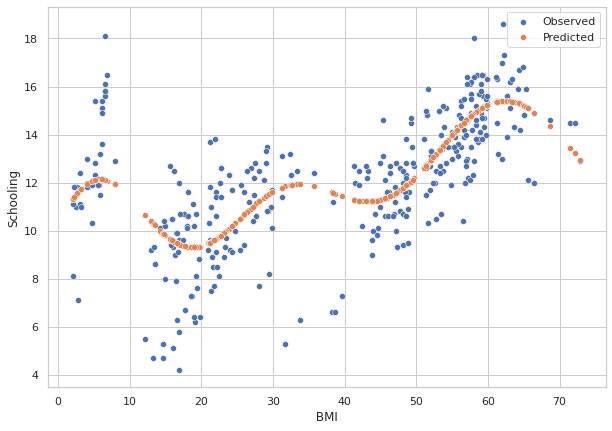

In [ ]:
predicted_df = pd.DataFrame({"Predicted": y_test_pred.ravel()}, index=X_test.index)
test_data_df = pd.concat([X_test, y_test, predicted_df], axis=1)

sns.scatterplot(data=test_data_df, x = " BMI ", y = "Schooling", label ="Observed") # observed
sns.scatterplot(data=test_data_df, x = " BMI ", y = "Predicted", label = "Predicted") # predicted

fig = plt.legend()

#### 2. Search for best hyperparameters for all models

Define models

In [ ]:
ln = ("ln", LinearRegression())
ln_params = dict()

svr = ("svr", SVR())
svr_params = dict(
    svr__kernel=["linear", "rbf"],
    svr__C=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 20, 50, 100],
    svr__epsilon=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10],
)

knn = ("knn", KNeighborsRegressor())
knn_params = dict(
    knn__n_neighbors=np.arange(1,50,2),
    knn__weights=['uniform', 'distance']
)

dt = ("dt", DecisionTreeRegressor())
dt_params = dict(
    dt__max_depth = np.arange(1,20,2)
)

estimators = [
    (ln, ln_params),
    (svr, svr_params),
    (knn, knn_params),
    (dt, dt_params)
]

Evaluate models with Grid Search


In [ ]:
results_df = pd.DataFrame()

# define basic steps of pre-processing
base_steps = [
    ('scaler', StandardScaler()), 
]

for estimator, params in estimators:
  print(f"Rating {estimator} \n")
  print(estimator)

  # create pipeline from base steps list and estimator
  pipe = Pipeline(base_steps + [estimator])

  # enter to grid search
  this_results = evaluate_GS_model(
      pipe,
      X_train,
      y_train,
      X_test,
      y_test,
      params,
      predict_test = False,
      predict_train = True,
  )

  results_df = results_df.append(this_results)

Rating ('ln', LinearRegression()) 

('ln', LinearRegression())
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END  neg_mean_absolute_error: (train=-1.792, test=-1.725) neg_mean_squared_error: (train=-5.557, test=-5.283) r2: (train=0.297, test=0.329) total time=   0.0s
[CV 2/3] END  neg_mean_absolute_error: (train=-1.702, test=-1.907) neg_mean_squared_error: (train=-5.049, test=-6.279) r2: (train=0.324, test=0.284) total time=   0.0s
[CV 3/3] END  neg_mean_absolute_error: (train=-1.815, test=-1.692) neg_mean_squared_error: (train=-5.758, test=-4.878) r2: (train=0.309, test=0.306) total time=   0.0s
Rating ('svr', SVR()) 

('svr', SVR())
Fitting 3 folds for each of 180 candidates, totalling 540 fits
[CV 1/3] END svr__C=1e-05, svr__epsilon=1e-05, svr__kernel=linear; neg_mean_absolute_error: (train=-2.228, test=-2.196) neg_mean_squared_error: (train=-7.919, test=-7.866) r2: (train=-0.002, test=0.001) total time=   0.0s
[CV 2/3] END svr__C=1e-05, svr__epsilon=1e-05, svr

In [ ]:
results_df

,model_name,train score,mean_cv_score,test_score,best_model,parameters,split0_test_r2,split1_test_r2,split2_test_r2
0,ln,0.309451,0.306414,None,"(StandardScaler(), LinearRegression())",{},0.329111,0.283848,0.306283
0,svr,0.585700,0.572254,None,"(StandardScaler(), SVR(C=100, epsilon=1))","{'svr__C': 100, 'svr__epsilon': 1, 'svr__kerne...",0.590200,0.550146,0.576414
0,knn,0.643392,0.603537,None,"(StandardScaler(), KNeighborsRegressor(n_neigh...","{'knn__n_neighbors': 25, 'knn__weights': 'unif...",0.614731,0.598722,0.597157
0,dt,0.654744,0.590374,None,"(StandardScaler(), DecisionTreeRegressor(max_d...",{'dt__max_depth': 5},0.624701,0.568365,0.578056


Which model is the best?

Let's check the validation (test) scores of models.

In [ ]:
results_df = pd.DataFrame()

# define basic steps of pre-processing
base_steps = [
    ('scaler', StandardScaler()), 
]

for (estimator, params) in estimators:
  print(f"Rating {estimator} \n")

  # create pipeline from base steps list and estimator
  pipe = Pipeline(base_steps + [estimator])

  # enter to grid search
  this_results = evaluate_GS_model(
      pipe,
      X_train,
      y_train,
      X_test,
      y_test,
      params,
      predict_test = True,
      predict_train = True,
  )

  results_df = results_df.append(this_results)

In [ ]:
results_df

,model_name,train score,mean_cv_score,test_score,best_model,parameters,split0_test_r2,split1_test_r2,split2_test_r2
0,ln,0.309451,0.306414,0.300507,"(StandardScaler(), LinearRegression())",{},0.329111,0.283848,0.306283
0,svr,0.585700,0.572254,0.579853,"(StandardScaler(), SVR(C=100, epsilon=1))","{'svr__C': 100, 'svr__epsilon': 1, 'svr__kerne...",0.590200,0.550146,0.576414
0,knn,0.643392,0.603537,0.615664,"(StandardScaler(), KNeighborsRegressor(n_neigh...","{'knn__n_neighbors': 25, 'knn__weights': 'unif...",0.614731,0.598722,0.597157
0,dt,0.654744,0.590374,0.615817,"(StandardScaler(), DecisionTreeRegressor(max_d...",{'dt__max_depth': 5},0.624701,0.568365,0.578056


## Best model: Problem 3 - whether KNN is really better than SVR?

It is hard to know whether the difference between mean scores is real or the result of a statistical fluke.

Statistical significance tests are designed to address this problem and quantify the likelihood of the samples of skill scores being observed given the assumption that they were drawn from the same distribution. If this assumption, or null hypothesis, is rejected, it suggests that the difference in skill scores is statistically significant.

**Statistical hypothesis tests can aid in comparing machine learning models and choosing a final model.**

In [ ]:
results_df = results_df.sort_values(by=["mean_cv_score"], ascending=False)
results_df

,model_name,train score,mean_cv_score,test_score,best_model,parameters,split0_test_r2,split1_test_r2,split2_test_r2
0,knn,0.643392,0.603537,0.615664,"(StandardScaler(), KNeighborsRegressor(n_neigh...","{'knn__n_neighbors': 25, 'knn__weights': 'unif...",0.614731,0.598722,0.597157
0,dt,0.654744,0.590374,0.615817,"(StandardScaler(), DecisionTreeRegressor(max_d...",{'dt__max_depth': 5},0.624701,0.568365,0.578056
0,svr,0.585700,0.572254,0.579853,"(StandardScaler(), SVR(C=100, epsilon=1))","{'svr__C': 100, 'svr__epsilon': 1, 'svr__kerne...",0.590200,0.550146,0.576414
0,ln,0.309451,0.306414,0.300507,"(StandardScaler(), LinearRegression())",{},0.329111,0.283848,0.306283


Take KNN and SVR models

In [ ]:
estimator1 = results_df.iloc[0].best_model
estimator2 = results_df.iloc[2].best_model

### Problem of Choosing a Hypothesis Test

Unfortunately, selecting an appropriate statistical hypothesis test for model selection in applied machine learning is more challenging than it first appears:

In an ideal world, we should have independent N data sets (samples) on which we would evaluate the model, and then compare the results of two models with each other (paired-t-test).

Unfortunately, rarely you will have enough data to train the model N times and evaluate it N times, everything on independent data sets (and we haven't reached the test set yet!).

That's why almost everybody uses CV scores as samples for the t-test in following way:

1. calculate CV scores for model A and model B;
2. calculate the difference between models' performance for each iteration of CV;
3.  perform t-test on those differences.

Following figure shows in a simplified way how such a procedure looks like: 

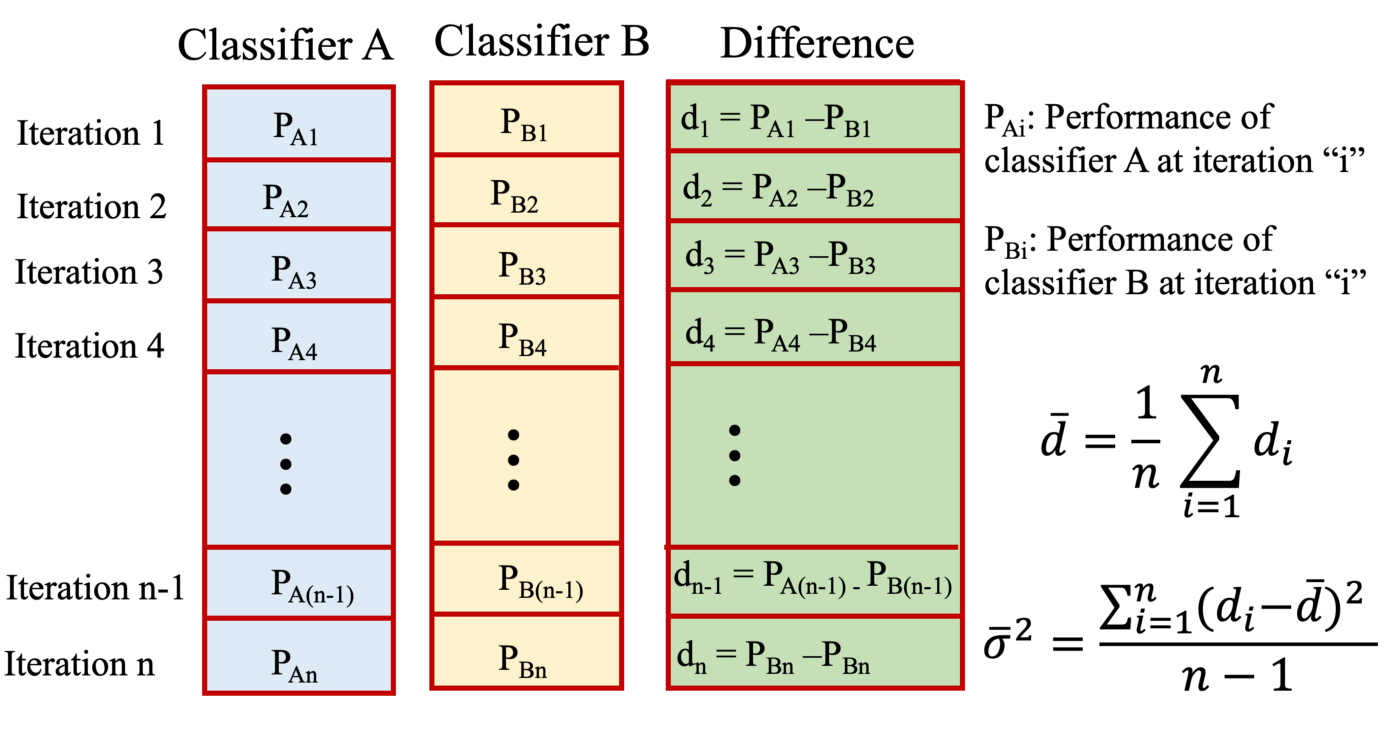

1. Why not simple Student’s t-test on CV scores

  Usage of CV scores violates Student't t-test assumptions!

  The observations in each sample are not independent. As part of the k-fold cross-validation procedure, a given observation will be used in the training dataset (k-1) times. This means that the estimated skill scores are dependent, not independent, and in turn that the calculation of the t-statistic in the test will be misleadingly wrong along with any interpretations of the statistic and p-value.

  **Fortunately, there is a growing body of research that suggests appropriate corrections and alternative methods.**





2. 5×2 Cross-Validation [(Dietterich, 1998)](https://ieeexplore.ieee.org/document/6790639)

  Resampling method: samples came from cross-validation that involves 5 repeats of 2-fold cross-validation.

  > The empirical results show that the 5 × 2cv paired t-test has a Type I error at or below the significance level. However, they also show that it has a much higher Type II error than the standard t-test applied to ten-fold cross-validation. Consequently the former test is recommended in when a low Type I error is essential, and the latter test otherwise.

  Implementation and overview: [`mlxtend`](http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_5x2cv/) library.

In [ ]:
from mlxtend.evaluate import paired_ttest_5x2cv

t, p = paired_ttest_5x2cv(
    estimator1=estimator1,
    estimator2=estimator2,
    X=X_train, 
    y=y_train,
    random_seed=random_state
)

print('t statistic: %.3f' % t)
print('p-value: %.3f' % p)

t statistic: 1.084
p-value: 0.328


3. Refinements on 5×2 Cross-Validation: [Nadeau & Bengio (2000)](https://proceedings.neurips.cc/paper/1999/file/7d12b66d3df6af8d429c1a357d8b9e1a-Paper.pdf) corrected t-test

  Resampling method: samples came from cross-validation that involves 10 repeats of 10-fold cross-validation. 

  > Empirical results show that this test dramatically improves on the standard resampled t-test: the Type I error is close to the significance level, and, unlike the 5×2 CV test, it does not suffer from high Type II error.

  Implementation: no off-the-shelf implementation. You may have to implement it yourself. Overview and hand-crafted implementation: [scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html#comparing-two-models-frequentist-approach) tutorial.



In [ ]:
def paired_ttest_nandeu(
    estimator1,
    estimator2,
    X,
    y,
    random_state=0  
):
  """Computes paired-ttest using Nadeau and Bengio's approach.

    Parameters
    ----------
    estimator1 : estimator object implementing 'fit'
        The object to use to fit the data.
    estimator2 :  estimator object implementing 'fit'
        The object to use to fit the data.
    X : array-like of shape at least 2D
        The data to fit.
    y : array-like of shape (n_samples,)
        The target variable to try to predict
    random_state: int


    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_value : float
        Variance-corrected p-value.
    """

  cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=random_state)
  
  cv_scores_1 = cross_val_score(estimator1, X, y, cv=cv)
  cv_scores_2 = cross_val_score(estimator2, X, y, cv=cv)

  differences = cv_scores_1 - cv_scores_2

  n = differences.shape[0]  # number of test sets
  df = n - 1
  n_train = len(list(cv.split(X, y))[0][0])
  n_test = len(list(cv.split(X, y))[0][1])

  t_stat, p_value = compute_corrected_ttest(differences, df, n_train, n_test)

  return t_stat, p_value


def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * ((1 / kr) + (n_test / n_train))
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes right-tailed paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = stats.t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [ ]:
t, p = paired_ttest_nandeu(
    estimator1=estimator1,
    estimator2=estimator2,
    X=X_train, 
    y=y_train,
    random_state=random_state
)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 3.273
p value: 0.001


We can visualize SVR vs KNN CV performance

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=random_state)
  
cv_scores_1 = cross_val_score(estimator1, X, y, cv=cv)
cv_scores_2 = cross_val_score(estimator2, X, y, cv=cv)

In [ ]:
cv_results_df = pd.DataFrame({
    "KNN": cv_scores_1,
    "SVR": cv_scores_2,
})

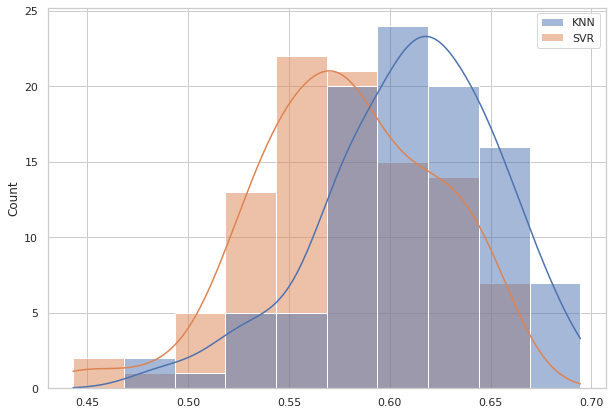

In [ ]:
fig = sns.histplot(data=cv_results_df, bins=10, kde=True)

### Recommendations on hypothesis tests

1. Think wh comparing models is necessary :)

  The availability and complexity of a chosen statistical method is an important consideration, said well by Gitte Vanwinckelen and Hendrik Blockeel in their 2012 paper titled [*On Estimating Model Accuracy with Repeated Cross-Validation*](https://limo.libis.be/primo-explore/fulldisplay?docid=LIRIAS1655861&context=L&vid=Lirias&search_scope=Lirias&tab=default_tab&lang=en_US&fromSitemap=1):

  > While these methods are carefully designed, and are shown to improve upon previous methods in a number of ways, they suffer from the same risk as previous methods, namely that the more complex a method is, the higher the risk that researchers will use it incorrectly, or interpret the result incorrectly.

2. If it is necessary, do not use simple Student't t-test. Use some of the proposed corrections, e.g., Nadeau & Bengio (2000).

## Readings

- [Statistical tests for comparing models](https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/) 🔥
- [Corrected paired Student't t-test - ELI5](https://medium.com/analytics-vidhya/using-the-corrected-paired-students-t-test-for-comparing-the-performance-of-machine-learning-dc6529eaa97f)
- Bouckaert, R. R., & Frank, E. (2004). [Evaluating the replicability of significance tests for comparing learning algorithms. In Pacific-Asia Conference on Knowledge Discovery and Data Mining](https://www.cms.waikato.ac.nz/~ml/publications/2004/bouckaert-frank.pdf).



# TODO 🔥

1. We're going to develop Perfectionism_project.ipynb further - EEG vs CMDA Perfectionism;
2. Like before, we base on EEG signal operationalized in the following way:
  - select one electrode;
  - select time window 0-100 ms;
  - average data in selected time window;
3. Extend tested models (Linear Regression, KNN and SVR) with Grid Seach for optimal parameters. 